In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import PartialDependenceDisplay
from xgboost import XGBRegressor
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression  
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
#TRATAMENTO DOS DADOS

df = pd.read_csv("Superstore2.csv", encoding="latin1")
#print(df.head())

# Corrigir nome da coluna Profit
df.rename(columns={'Profit;': 'Profit'}, inplace=True)

# Corrigir formato das colunas de datas
df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')
df['Ship Date'] = pd.to_datetime(df['Ship Date'], errors='coerce')

# Corrigir valores da coluna Profit
df['Profit'] = df['Profit'].astype(str).str.replace(';', '', regex=False)
df['Profit'] = df['Profit'].str.replace(',', '.', regex=False)
df['Profit'] = pd.to_numeric(df['Profit'], errors='coerce')

# Criar novas features numéricas
df['Order_Year'] = df['Order Date'].dt.year
df['Order_Month'] = df['Order Date'].dt.month
df['Delivery_Days'] = (df['Ship Date'] - df['Order Date']).dt.days
df['Quarter'] = df['Order Date'].dt.quarter

df['Discounted_Value'] = df['Sales'] * df['Discount']

In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Row ID            9994 non-null   object        
 1   Order ID          7484 non-null   object        
 2   Order Date        7484 non-null   datetime64[ns]
 3   Ship Date         7484 non-null   datetime64[ns]
 4   Ship Mode         7484 non-null   object        
 5   Customer ID       7484 non-null   object        
 6   Customer Name     7484 non-null   object        
 7   Segment           7484 non-null   object        
 8   Country           7484 non-null   object        
 9   City              7484 non-null   object        
 10  State             7484 non-null   object        
 11  Postal Code       7484 non-null   float64       
 12  Region            7484 non-null   object        
 13  Product ID        7484 non-null   object        
 14  Category          7484 n

In [4]:
print(df.isnull().sum())

Row ID                 0
Order ID            2510
Order Date          2510
Ship Date           2510
Ship Mode           2510
Customer ID         2510
Customer Name       2510
Segment             2510
Country             2510
City                2510
State               2510
Postal Code         2510
Region              2510
Product ID          2510
Category            2510
Sub-Category        2510
Product Name        2510
Sales               2510
Quantity            2510
Discount            2510
Profit              2510
Order_Year          2510
Order_Month         2510
Delivery_Days       2510
Quarter             2510
Discounted_Value    2510
dtype: int64


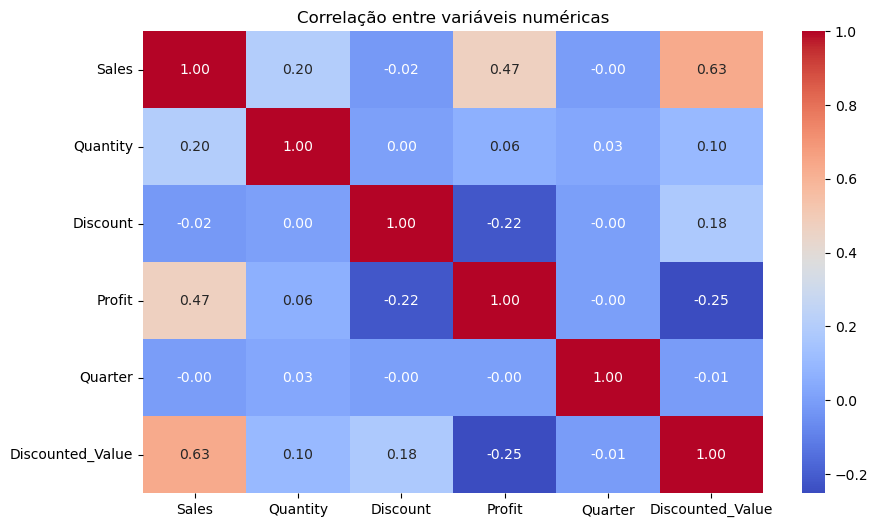

In [6]:
# GRÁFICO DE CORRELAÇÃO

# Selecionar colunas numéricas para correlação
num_cols = ['Sales', 'Quantity', 'Discount', 'Profit', 'Quarter', 'Discounted_Value']

# Eliminar linhas com NaN nessas colunas
df_corr = df[num_cols].dropna()

plt.figure(figsize=(10, 6))
sns.heatmap(df_corr.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlação entre variáveis numéricas')
plt.show()


In [10]:
#CORRELAÇÃO COM MAIS VARIÁVEIS E COM VARIÁVEIS DUMMY

# Remover colunas irrelevantes
colunas_a_remover = ['Order ID', 'Customer ID', 'Customer Name', 'Product ID', 'Product Name', 'Postal Code', 'Country']
df_modelo = df.drop(columns=colunas_a_remover)

# Selecionar variáveis que você quer manter (numéricas)
variaveis_numericas = ['Sales', 'Quantity', 'Discount', 'Profit', 'Quarter', 'Discounted_Value']

# Separar as que você quer transformar em dummies
colunas_para_dummy = ['City', 'State', 'Region', 'Category', 'Sub-Category', 'Segment']

# Transformar em dummies, mantendo as numéricas
df_dummies = pd.get_dummies(df_modelo[variaveis_numericas + colunas_para_dummy], drop_first=True)

# Eliminar NaN, se houver
df_corr = df_dummies.dropna()

# Gerar gráfico
#plt.figure(figsize=(20, 15))
#sns.heatmap(df_corr.corr(), cmap='coolwarm', annot=False)
#plt.title('Correlação entre variáveis numéricas e dummies')
#plt.show()

In [30]:
#MODELO LINEAR

# Remover colunas irrelevantes ou não numéricas
#colunas_a_remover = ['Order ID', 'Customer ID', 'Customer Name', 'Product ID', 'Product Name', 'Postal Code', 'Country']
colunas_a_remover = ['Order ID', 'Customer ID', 'Customer Name', 'Product ID', 'Product Name', 'Postal Code', 'Country', 'Ship Date','Ship Mode']

colunas_para_dummy = ['City', 'State', 'Region', 'Category', 'Sub-Category', 'Segment', 'Ship Mode','Order Date', 'Ship Date']


df_modelo = df.drop(columns=colunas_a_remover)

# Criar dummies para colunas categóricas
#colunas_para_dummy = ['City', 'State', 'Region', 'Category', 'Sub-Category', 'Segment', 'Ship Mode','Order Date', 'Ship Date']
colunas_para_dummy = ['City', 'State', 'Region', 'Category', 'Sub-Category', 'Segment','Order Date']
df_dummies = pd.get_dummies(df_modelo, columns=colunas_para_dummy, drop_first=True)

# Remover linhas com valores faltantes
df_dummies = df_dummies.dropna()

# Separar X e y
X = df_dummies.drop(columns=['Sales'])
y = df_dummies['Sales']

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Tamanho do conjunto de treino: {X_train.shape}")
print(f"Tamanho do conjunto de teste: {X_test.shape}")

# Treinar modelo
model = LinearRegression()
model.fit(X_train, y_train)

# Prever
y_pred = model.predict(X_test)

# Avaliar
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nMSE: {mse:.2f}")
print(f"R²: {r2:.2f}")

Tamanho do conjunto de treino: (5987, 1770)
Tamanho do conjunto de teste: (1497, 1770)

MSE: 80500.09
R²: 0.69


In [8]:
#ESCLA LASSO

df_dummies = df_dummies.dropna()
X = df_dummies.drop(columns=['Profit'])
y = df_dummies['Profit']

# Escalonar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Lasso com validação cruzada
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_scaled, y)

# Ver variáveis com coeficiente diferente de zero
coef_lasso = pd.Series(lasso.coef_, index=X.columns)
variaveis_importantes = coef_lasso[coef_lasso != 0].sort_values(ascending=False)
print(variaveis_importantes)


Sales                       253.907071
Sub-Category_Copiers         25.689469
Sub-Category_Binders          5.869854
Category_Office Supplies      3.790741
Sub-Category_Paper            1.995335
City_San Antonio             -0.996392
Sub-Category_Machines        -2.263775
City_Burlington              -2.951171
City_Lancaster               -3.675657
City_Round Rock              -3.998177
Sub-Category_Bookcases       -4.757214
Quantity                     -6.796113
Sub-Category_Chairs          -7.266523
Sub-Category_Supplies        -7.509274
Sub-Category_Storage         -8.077056
Discount                     -9.817215
Sub-Category_Tables         -14.992022
Discounted_Value           -218.253044
dtype: float64


RMSE: 99.43
R²: 0.5705


C:\Users\Usuario\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


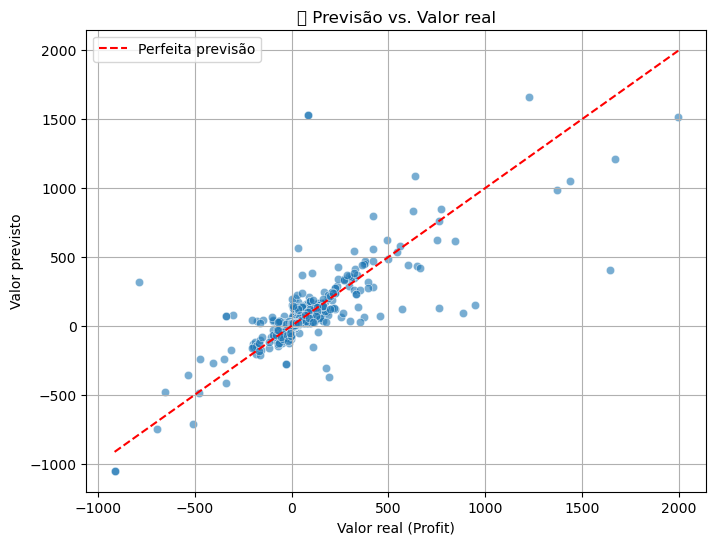

In [12]:
# MODELO DE REGRESSÃO POLINOMIAL COM MENOS VARIÁVEIS

# Remover linhas com valores faltantes
df_dummies = df_dummies.dropna()

# Variáveis numéricas mais importantes
variaveis = ['Sales', 'Discount', 'Quantity']
X = df_dummies[variaveis]
y = df_dummies['Profit']

# Escalonamento
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Criar termos polinomiais (somente interações)
poly = PolynomialFeatures(degree=2, include_bias=False)
#interaction_only=True
X_poly = poly.fit_transform(X_scaled)

# Treinar e avaliar
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)
modelo = LinearRegression()
modelo.fit(X_train, y_train)

y_pred = modelo.predict(X_test)
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"R²: {r2_score(y_test, y_pred):.4f}")

# Gráfico de previsão vs valor real
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Perfeita previsão')
plt.xlabel("Valor real (Profit)")
plt.ylabel("Valor previsto")
plt.title("🔍 Previsão vs. Valor real")
plt.legend()
plt.grid(True)
plt.show()

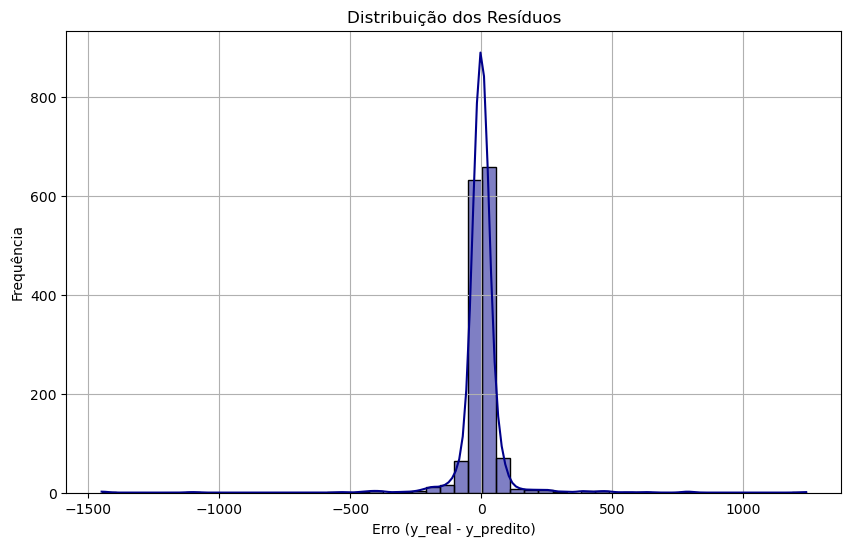

In [41]:
#DISTRIBUIÇÃO DE RESÍDUO DO MODELO DE REGRESSÃO POLINOMIAL

residuos = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuos, bins=50, kde=True, color='darkblue')
plt.title("Distribuição dos Resíduos")
plt.xlabel("Erro (y_real - y_predito)")
plt.ylabel("Frequência")
plt.grid(True)
plt.show()

📊 RMSE: 81.17
📈 R²: 0.7138


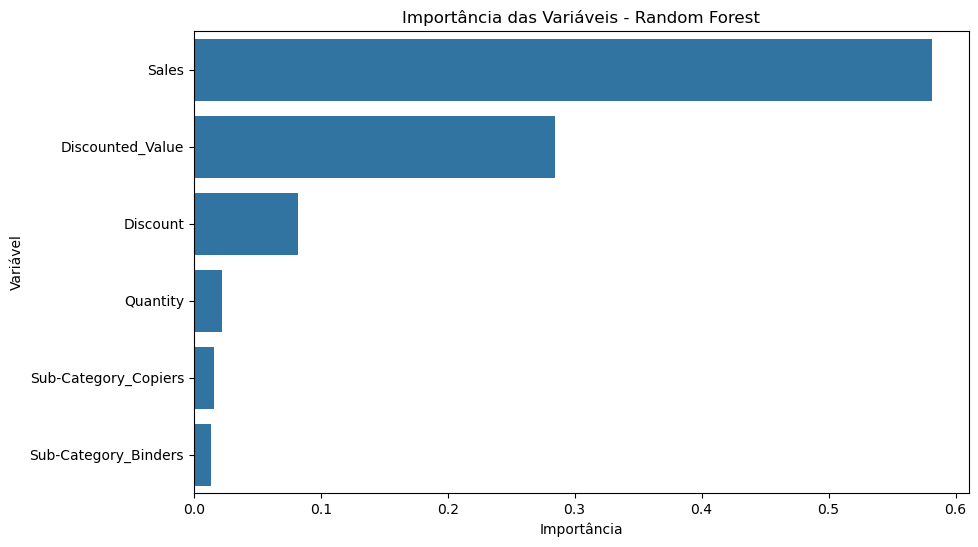

In [13]:
#MODELO RANDOM FOREST

# Variáveis numéricas mais importantes
variaveis = ['Sales', 'Discount', 'Quantity', 'Sub-Category_Copiers', 'Sub-Category_Binders', 'Discounted_Value']
X = df_dummies[variaveis]
y = df_dummies['Profit']

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criar o modelo Random Forest
modelo = RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_split=5, random_state=42)

# Treinar o modelo
modelo.fit(X_train, y_train)

# Fazer previsões
y_pred = modelo.predict(X_test)

# Avaliar o modelo
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"📊 RMSE: {rmse:.2f}")
print(f"📈 R²: {r2:.4f}")

# Importância das variáveis
importancias = pd.Series(modelo.feature_importances_, index=X.columns)
importancias = importancias.sort_values(ascending=False)

# Visualizar a importância
plt.figure(figsize=(10,6))
sns.barplot(x=importancias.values, y=importancias.index)
plt.title("Importância das Variáveis - Random Forest")
plt.xlabel("Importância")
plt.ylabel("Variável")
plt.show()

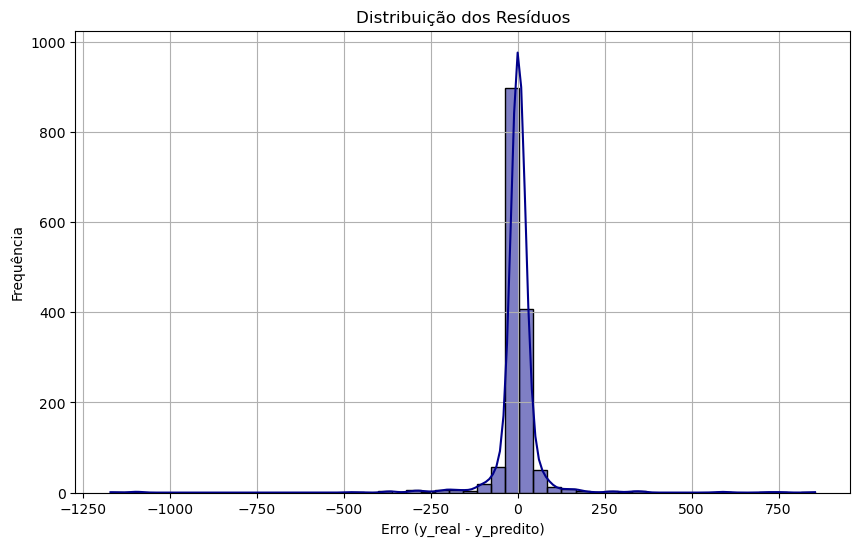

In [22]:
#DISTRIBUIÇÃO DE RESÍDUOS DO MODELO RANDOM FOREST

residuos = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuos, bins=50, kde=True, color='darkblue')
plt.title("Distribuição dos Resíduos")
plt.xlabel("Erro (y_real - y_predito)")
plt.ylabel("Frequência")
plt.grid(True)
plt.show()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_11944\3143164723.py:7: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Usuario\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


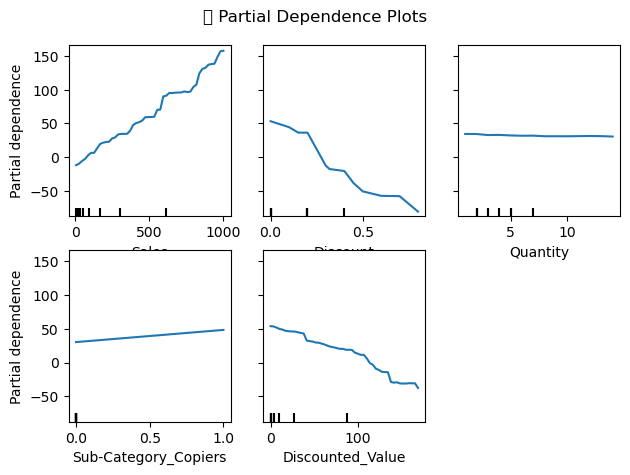

In [43]:
#Partial Dependence Plots (PDPs) do random forest acima

features = ['Sales', 'Discount', 'Quantity', 'Sub-Category_Copiers','Discounted_Value']

disp = PartialDependenceDisplay.from_estimator(modelo, X_train, features, kind="average", grid_resolution=50)
disp.figure_.suptitle("🔍 Partial Dependence Plots")
plt.tight_layout()
plt.show()

In [15]:
df_dummies.columns

Index(['Sales', 'Quantity', 'Discount', 'Profit', 'City_Abilene', 'City_Akron',
       'City_Albuquerque', 'City_Alexandria', 'City_Allen', 'City_Allentown',
       ...
       'Sub-Category_Furnishings', 'Sub-Category_Labels',
       'Sub-Category_Machines', 'Sub-Category_Paper', 'Sub-Category_Phones',
       'Sub-Category_Storage', 'Sub-Category_Supplies', 'Sub-Category_Tables',
       'Segment_Corporate', 'Segment_Home Office'],
      dtype='object', length=575)

In [17]:
#MODELO XGBOOST

# Variáveis numéricas mais importantes
variaveis = ['Sales', 'Discount', 'Quantity', 'Sub-Category_Copiers', 'Sub-Category_Binders', 'Discounted_Value']
X = df_dummies[variaveis]
y = df_dummies['Profit']

# Treinar/testar
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo XGBoost
modelo_xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Treinar
modelo_xgb.fit(X_train, y_train)

# Previsão e avaliação
y_pred = modelo.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"📊 RMSE: {rmse:.2f}")
print(f"📈 R²: {r2:.4f}")

📊 RMSE: 81.17
📈 R²: 0.7138


C:\Users\Usuario\AppData\Local\Temp\ipykernel_10232\2873320314.py:6: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Usuario\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


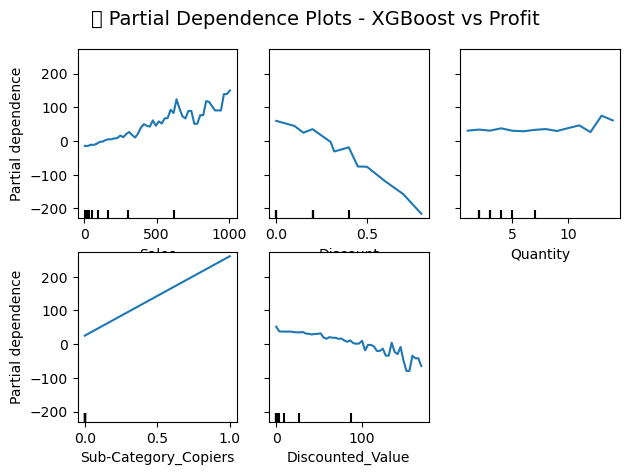

In [18]:
#Partial Dependence Plots (PDPs) do XGBoost acima
features = ['Sales', 'Discount', 'Quantity', 'Sub-Category_Copiers', 'Discounted_Value']

PartialDependenceDisplay.from_estimator(modelo_xgb, X_train, features, kind="average", grid_resolution=50)
plt.suptitle("📈 Partial Dependence Plots - XGBoost vs Profit", fontsize=14)
plt.tight_layout()
plt.show()


C:\Users\Usuario\AppData\Local\Temp\ipykernel_10232\447353774.py:12: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Usuario\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


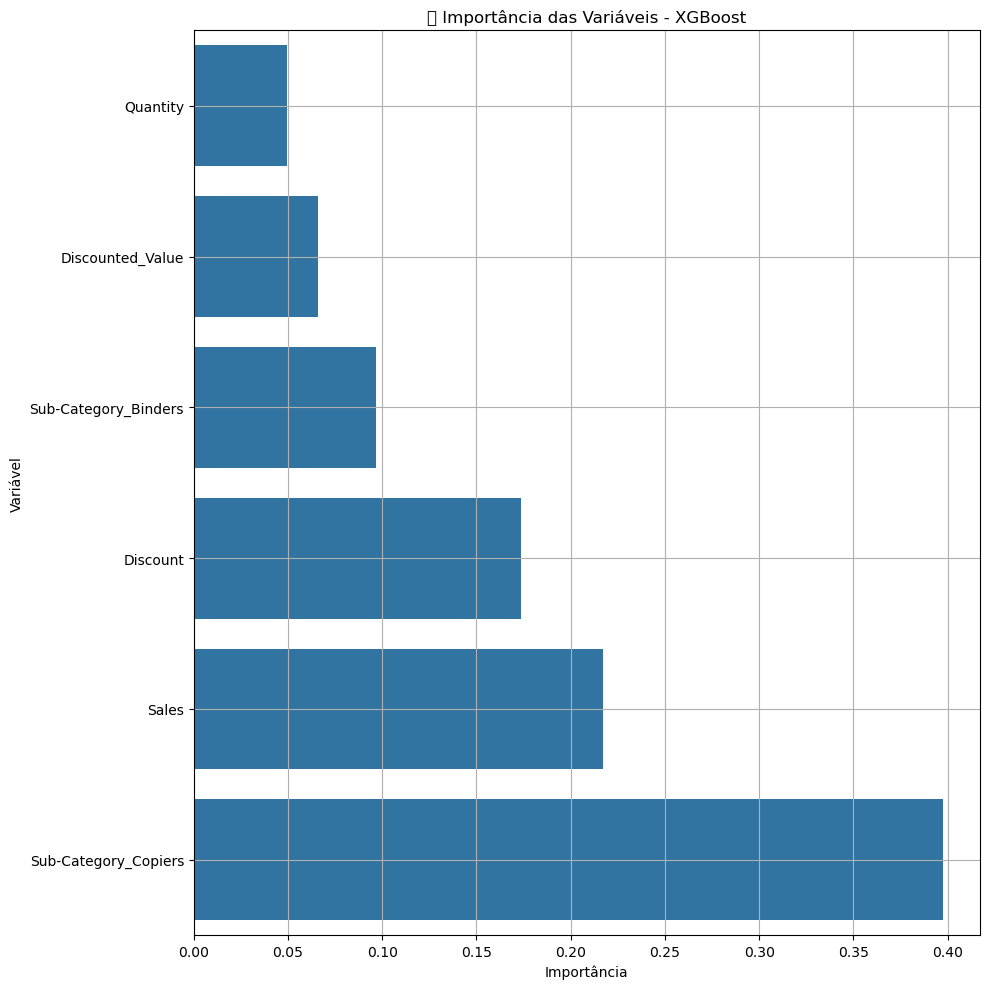

In [19]:
#GRÁFICO DAS IMPORTÂNCIAS DAS VARIÁVEIS DO XGBOOST

importancias = pd.Series(modelo_xgb.feature_importances_, index=X.columns)
importancias = importancias.sort_values(ascending=True)

plt.figure(figsize=(10,10))
sns.barplot(x=importancias.values, y=importancias.index)
plt.title("🔍 Importância das Variáveis - XGBoost")
plt.xlabel("Importância")
plt.ylabel("Variável")
plt.grid(True)
plt.tight_layout()
plt.show()

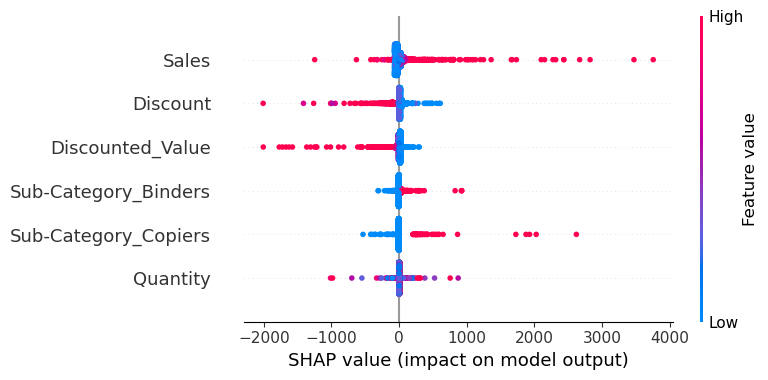

In [20]:
#GRÁFICO SHAP DO MODELO XGBOOST
explainer = shap.Explainer(modelo_xgb)
shap_values = explainer(X_train)

# Gráfico de resumo
shap.summary_plot(shap_values, X_train)

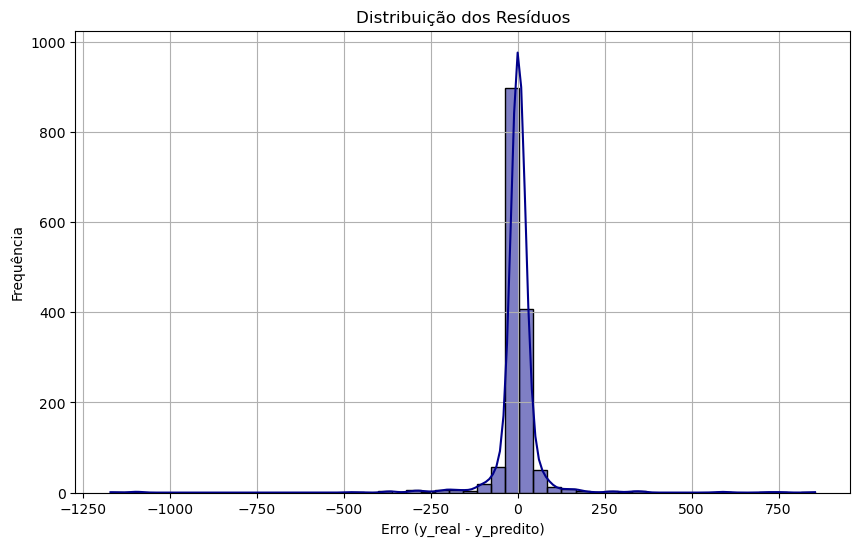

In [21]:
#DISTRIBUIÇÃO DE RESÍDUOS SO MODELO XGBOOST

residuos = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuos, bins=50, kde=True, color='darkblue')
plt.title("Distribuição dos Resíduos")
plt.xlabel("Erro (y_real - y_predito)")
plt.ylabel("Frequência")
plt.grid(True)
plt.show()

In [26]:
#AJUSTE DE HIPERPARÂMETROS MENOS ROBUSTO

# Define o espaço de busca dos hiperparâmetros
espaco_parametros = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Configura a busca aleatória
busca_aleatoria = RandomizedSearchCV(
    estimator=modelo_xgb,
    param_distributions=espaco_parametros,
    n_iter=10,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=42
)

# Treinamento do modelo
busca_aleatoria.fit(X_train, y_train)

# Imprime os melhores resultados
print("Melhores parâmetros:", busca_aleatoria.best_params_)
print("Melhor RMSE:", np.sqrt(-busca_aleatoria.best_score_))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Melhores parâmetros: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2}
Melhor RMSE: 142.8304522295174


In [27]:
#AJUSTE DE HIPERPARÂMETROS MAIS ROBUSTO

# Espaço de busca mais amplo para os hiperparâmetros
espaco_parametros = {
    'n_estimators': [100, 500, 1000, 1500, 2000],  
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],        
    'learning_rate': np.arange(0.01, 0.3, 0.01),   
    'subsample': np.arange(0.5, 1.0, 0.1),
    'colsample_bytree': np.arange(0.5, 1.0, 0.1),
    'gamma': np.arange(0, 0.5, 0.1),
    'reg_alpha': np.arange(0, 0.5, 0.1)
}

# Busca aleatória com mais iterações
random_search = RandomizedSearchCV(
    estimator=modelo_xgb,
    param_distributions=espaco_parametros,
    n_iter=100,  # Aumentamos para 100 iterações para uma busca mais completa
    scoring='neg_mean_squared_error',
    cv=5, # Usamos 5 folds para uma validação cruzada mais robusta
    verbose=1,
    random_state=42
)

# Treinamento do modelo
random_search.fit(X_train, y_train)

# Imprima os melhores resultados
print(f"Melhor RMSE na validação cruzada: {np.sqrt(-random_search.best_score_):.4f}")
print("Melhores parâmetros encontrados:")
print(random_search.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Melhor RMSE na validação cruzada: 139.9336
Melhores parâmetros encontrados:
{'subsample': 0.5, 'reg_alpha': 0.2, 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.060000000000000005, 'gamma': 0.30000000000000004, 'colsample_bytree': 0.7999999999999999}


In [23]:
#MODELO XGBOOST COM OS HIPERPARÂMETROS ENCONTRADOS NO AJUSTE MAIS ROBUSTO

# Modelo
melhor_modelo_ajustado = XGBRegressor(
    subsample=0.5,
    reg_alpha=0.2,
    n_estimators=500,
    max_depth=3,
    learning_rate=0.06,
    gamma=0.3,
    colsample_bytree=0.8,
    random_state=42
)

# Treinemento do modelo
melhor_modelo_ajustado.fit(X_train, y_train)

# Previsão e avaliação
y_pred = modelo.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"📊 RMSE: {rmse:.2f}")
print(f"📈 R²: {r2:.4f}")

📊 RMSE: 81.17
📈 R²: 0.7138


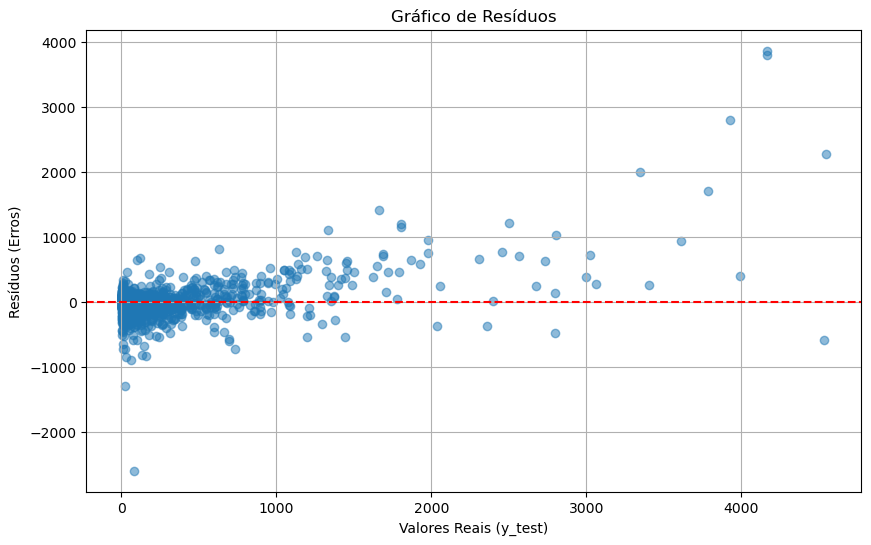

In [31]:
#RESÍDUOS DO MODELOS XGBOOST MAIS ROBUSTO
residuos = y_test - y_pred

# Crie o gráfico de dispersão
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuos, alpha=0.5)
plt.title('Gráfico de Resíduos')
plt.xlabel('Valores Reais (y_test)')
plt.ylabel('Resíduos (Erros)')
plt.axhline(y=0, color='r', linestyle='--')
plt.grid(True)
plt.show()

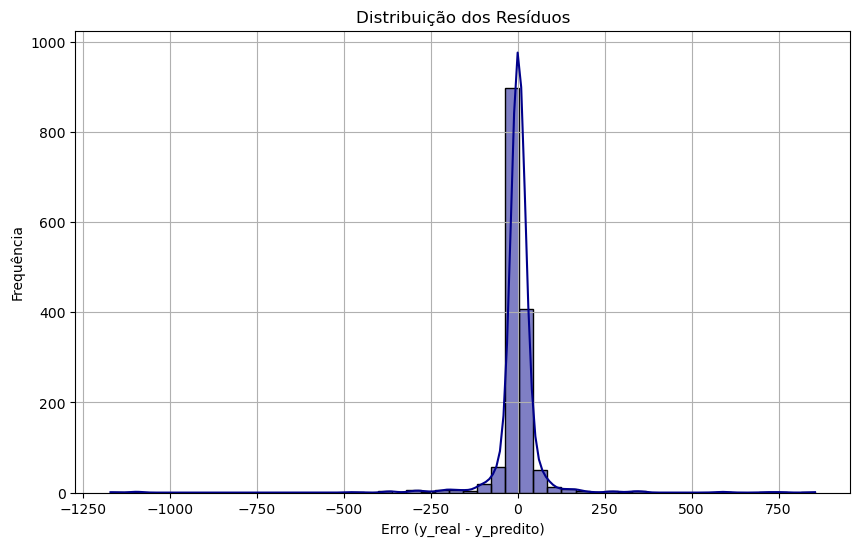

In [26]:
residuos = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuos, bins=50, kde=True, color='darkblue')
plt.title("Distribuição dos Resíduos")
plt.xlabel("Erro (y_real - y_predito)")
plt.ylabel("Frequência")
plt.grid(True)
plt.show()

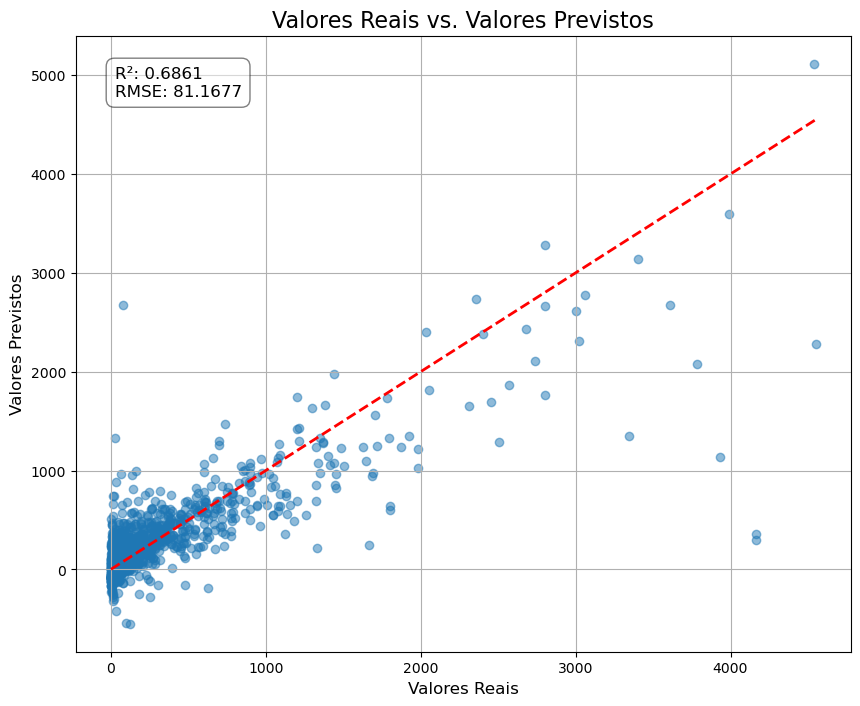

In [33]:
#PREVISÃO DO MODELO

plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, alpha=0.5)

# Plote a linha de previsão perfeita (y = x)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)

# Adicione o título e rótulos
plt.title('Valores Reais vs. Valores Previstos', fontsize=16)
plt.xlabel('Valores Reais', fontsize=12)
plt.ylabel('Valores Previstos', fontsize=12)
plt.grid(True)

# Adicione as métricas R² e RMSE no gráfico
plt.text(0.05, 0.95, f'R²: {r2:.4f}\nRMSE: {rmse:.4f}', 
         transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.5))

plt.show()